In [1]:
import functools
import math
import numpy as np
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
sns.set_style("white")

import matplotlib as plt
plt.rcParams['figure.figsize'] = (8,6)

from IPython.display import display

### Load Database

In [2]:
%run AH_DATABASE.ipynb


Usage: 
  db = DB(server)          --> initializes database
  db.get_df(item)          --> returns dataframe, prices divided by 100 so copper in decimal 
  db.get_name(item)        --> returns name of item  
  db.get_last_record(item) --> returns most recent record
  db.plot(item, y)         --> plots column over time



In [35]:
db = DB('earthfury-alliance', timerange=21)

In [36]:
item = 2840 # copper bar

### Percentile Functions

In [37]:
def pctBelowValue(series, value):
    return stats.percentileofscore(series, value)/100

def pctAboveValue(series, value):
    return 1-stats.percentileofscore(series, value)/100

def valueAtPctile(series, pctile):
    return series.quantile(pctile)
    

### Daily Rollups

In [38]:
def dailyMax(item, column='minBuyout'):
    # use pctile instead of max() to avoid outliers, and tweak demand assumptions
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)[column].quantile(.7)

def dailyMin(item, column='minBuyout'):
    # use 10 pctile instead of min() to avoid outliers
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)[column].quantile(.1)

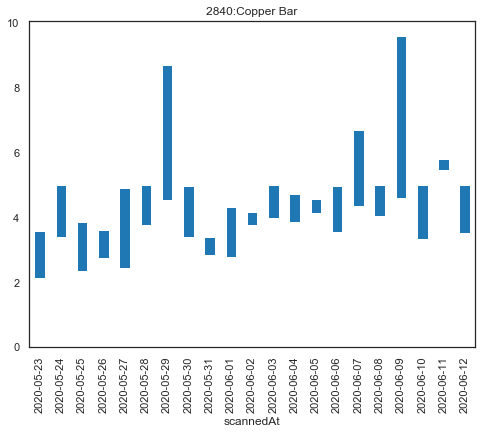

In [39]:
def plotDailyRange(item, buyAt=None, sellAt=None):
    title = f'{item}:{db.get_name(item)}'
        
    # create bars
    _, ax = plt.subplots()
    dailyMax(item).plot(kind='bar', x='scannedAt', y='minBuyout', title=title, ax=ax)
    dailyMin(item).plot(kind='bar', x='scannedAt', y='minBuyout', color='w', ax=ax)
    
    # add buy lines if passed
    if buyAt and sellAt:
        ax.axhline(y=buyAt, color='red')
        ax.axhline(y=sellAt, color='green')

    
plotDailyRange(item)

### Analysis

In [40]:
def postcost_at_salerate(item, salerate):
    if salerate == 0:
        return 0
    vp = db.get_vendorprice(item) # double check this value is working correctly using in game reference 
    return (1-salerate) / salerate * (.6*vp)

def iterPrice(item):
    # iterate from min price to max price in .01 percentile steps
    for pctile in np.arange(0, 1, .01):
        yield db.get_df_hourly(item)['minBuyout'].quantile(pctile)

,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,flipRate,timeValue,roi
48,8153,Wildvine,114.84,0.761905,0.009375,109.098,99.238367,0.298805,15.592258,0.227661,3.549746,0.035767


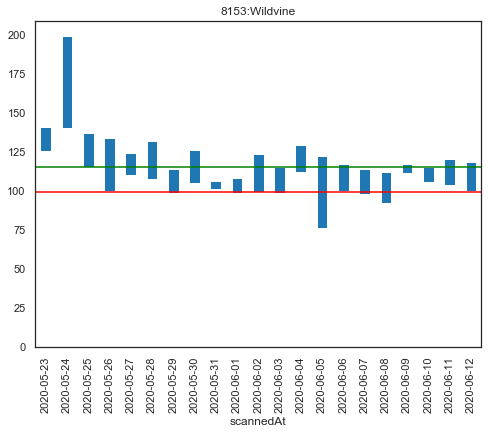

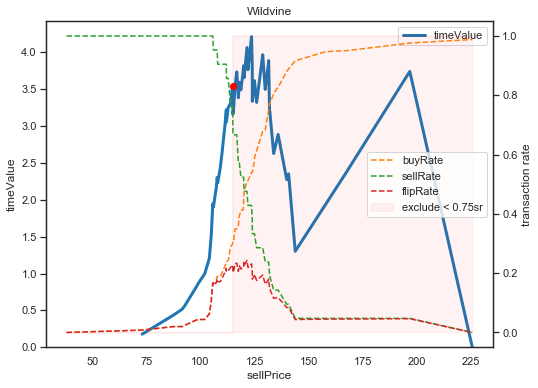

In [97]:
def analysis(item, show=False, minSellRate=.5):
    data = []
    for sellPrice in iterPrice(item):
        sellRate = pctAboveValue(dailyMax(item), sellPrice) # use dailyMax series due to selling pattern

        # expected posting cost based on avail sell
        postCost = postcost_at_salerate(item, sellRate)

        # buying values
        maxBuy   = sellPrice * .95
        meanBuy  = db.get_df_hourly(item).query('minBuyout <= @maxBuy')['minBuyout'].mean()
        buyRate  = pctBelowValue(db.get_df_hourly(item)['minBuyout'], maxBuy) # use hourly series due to buying pattern        

        # profit
        value = sellPrice - meanBuy - postCost
        timeValue = value * sellRate * buyRate
        roi = timeValue / (meanBuy + postCost)        
        
        # load into data
        data.append({
            'item_id'  :item,
            'name'     :db.get_name(item),
            'sellPrice':sellPrice,
            'sellRate' :sellRate, 
            'postCost' :postCost,
            'maxBuy'   :maxBuy, 
            'meanBuy'  :meanBuy,
            'buyRate'  :buyRate,
            'value'    :value, 
            'flipRate' :sellRate * buyRate,
            'timeValue':timeValue, 
            'roi'      :roi,        
        })

    # data frame for analysis
    df = pd.DataFrame(data)    
    best = df.loc[df['roi'] == df.query('sellRate > @minSellRate')['roi'].max()]
    if best.empty:
        # if no optimal found above cutoff, find best anyway
        best = df.loc[df['roi'] == df['roi'].max()]
    
    if show:
        # plot daily range and buy/sell lines
        display(best)
        plotDailyRange(item, best.iloc[0]['meanBuy'], best.iloc[0]['sellPrice'])
        
        # plot analysis curve
        _, ax = plt.subplots()
        df.plot(x='sellPrice', y=['timeValue'], title=db.get_name(item), linewidth=3, ax=ax)
        plt.plot(best['sellPrice'],best['timeValue'],'ro') 
        
        # create exclusion zone based on cutoff
        exclude_name = f'exclude < {minSellRate}sr'
        df[exclude_name] = df['sellRate'].apply(lambda x: x<minSellRate).astype(int)
        df.plot(kind='area', x='sellPrice', y=exclude_name, secondary_y=True, color='red', alpha=.05, ax=ax, legend=False)
        
        # plot roi and rates
        df.plot(x='sellPrice', y=['buyRate', 'sellRate', 'flipRate'], style='--', secondary_y=True, ax=ax, legend=False).legend(loc='center right')
        ax.set_ylabel('timeValue')
        ax.right_ax.set_ylabel('transaction rate')
        return
    return best.to_dict('r')[0]
    
analysis(8153, show=True, minSellRate=.75)

### Full Run

In [98]:
%run ITEMS.ipynb


loaded
  herbs       : 30 items
  cloth       : 12 items
  mining      : 27 items
  enchant     : 24 items
  skinning    : 11 items
  meat        : 27 items
  consumables : 44 items
  eng         : 53 items
  ALL         : 228 items



In [102]:
%%time

# a bunch of printing and error catching, to simply map(fn, list_of_items)
def run_analysis(list_of_items, fn):
    print(f'running for {len(list_of_items)} items')    
    results = []    
    for i, item in enumerate(list_of_items):       
        # catch no data errors with try/except
        try:
            results.append(fn(item))
        except: 
            print(f'! ERROR - {item}, {db.get_name(item)}')
        # print progress
        if i%10 ==0: print(f' ...{i} done')   
    print('COMPLETE')
    return pd.DataFrame(results).round(2)

df = run_analysis(ALL, analysis)

running for 228 items
 ...0 done
 ...10 done
 ...20 done
 ...30 done
 ...40 done
 ...50 done
 ...60 done
! ERROR - 17771, Elementium Bar
! ERROR - 3861, Blacksteel Bar
 ...70 done
 ...80 done
 ...90 done
! ERROR - 20725, Nexus Crystal
 ...100 done
 ...110 done
 ...120 done
! ERROR - 5467, Kodo Meat
 ...130 done
 ...140 done
! ERROR - 20748, Brilliant Mana Oil
! ERROR - 20749, Brilliant Wizard Oil
! ERROR - 21546, Elixir of Greater Firepower
 ...150 done
 ...160 done
 ...170 done
! ERROR - 21023, Dirge's Kickin' Chimaerok Chops
 ...180 done
 ...190 done
 ...200 done
 ...210 done
! ERROR - 4399, Wooden Stock
! ERROR - 4400, Heavy Stock
 ...220 done
COMPLETE
Wall time: 3min 18s


### Augment Result with additional columns

In [103]:
df['quantity'] = df['item_id'].apply(lambda x : int(db.get_df(x)['quantity'].mean()))

# looking at std and stuff
# df['std']  = df['item_id'].apply(lambda x: db.get_df_hourly(x)['minBuyout'].std())
# df['mean'] = df['item_id'].apply(lambda x: db.get_df_hourly(x)['minBuyout'].mean())
# df['coefVar'] = df['std']/df['mean']
# df = df.round(2)

df.head()

,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,flipRate,timeValue,roi,quantity
0,8153,Wildvine,119.99,0.52,0.03,113.99,102.86,0.43,17.10,0.22,3.82,0.04,136
1,8836,Arthas' Tears,4.75,0.90,0.06,4.51,3.73,0.25,0.96,0.23,0.22,0.06,104
2,13468,Black Lotus,14800.00,0.52,5.45,14060.00,12938.45,0.47,1856.10,0.25,459.01,0.04,21
3,13466,Plaguebloom,254.00,0.62,0.92,241.30,226.08,0.40,27.00,0.25,6.63,0.03,272
4,13465,Mountain Silversage,145.12,0.62,0.55,137.87,128.14,0.46,16.44,0.29,4.72,0.04,432


In [119]:
# set restock, based on 100x sungrass restock
scalar = df.query('name == "Sungrass"')['quantity'].iloc[0]
df['restock'] = (100 * df['quantity'] / scalar).astype(int)
df.head()

,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,flipRate,timeValue,roi,quantity,restock
0,8153,Wildvine,119.99,0.52,0.03,113.99,102.86,0.43,17.10,0.22,3.82,0.04,136,45
1,8836,Arthas' Tears,4.75,0.90,0.06,4.51,3.73,0.25,0.96,0.23,0.22,0.06,104,34
2,13468,Black Lotus,14800.00,0.52,5.45,14060.00,12938.45,0.47,1856.10,0.25,459.01,0.04,21,7
3,13466,Plaguebloom,254.00,0.62,0.92,241.30,226.08,0.40,27.00,0.25,6.63,0.03,272,91
4,13465,Mountain Silversage,145.12,0.62,0.55,137.87,128.14,0.46,16.44,0.29,4.72,0.04,432,144


### Create Choice

In [120]:
choice = df.query('quantity>100 and sellPrice>2')

pd.set_option('display.max_rows', None)
choice.sort_values(by='sellRate')

,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,flipRate,timeValue,roi,quantity,restock
0,8153,Wildvine,119.99,0.52,0.03,113.99,102.86,0.43,17.10,0.22,3.82,0.04,136,45
165,20452,Smoked Desert Dumplings,233.32,0.52,1.36,221.65,192.31,0.48,39.65,0.25,10.03,0.05,230,77
163,13931,Nightfin Soup,50.96,0.52,0.07,48.41,42.94,0.46,7.96,0.24,1.91,0.04,579,194
162,13928,Grilled Squid,158.25,0.52,0.04,150.34,128.77,0.52,29.44,0.27,8.06,0.06,354,118
159,5634,Free Action Potion,112.72,0.52,0.41,107.09,98.95,0.43,13.37,0.22,2.98,0.03,237,79
146,9206,Elixir of Giants,124.98,0.52,3.82,118.73,112.15,0.39,9.01,0.20,1.84,0.02,114,38
93,2319,Medium Leather,2.03,0.52,0.27,1.93,1.27,0.56,0.48,0.29,0.14,0.09,303,101
89,14344,Large Brilliant Shard,275.00,0.52,0.00,261.25,236.70,0.53,38.30,0.28,10.63,0.04,594,199
82,10978,Small Glimmering Shard,3.06,0.52,0.00,2.91,1.67,0.57,1.39,0.30,0.42,0.25,272,91
81,16203,Greater Eternal Essence,499.99,0.52,0.00,474.99,436.22,0.49,63.77,0.26,16.44,0.04,293,98


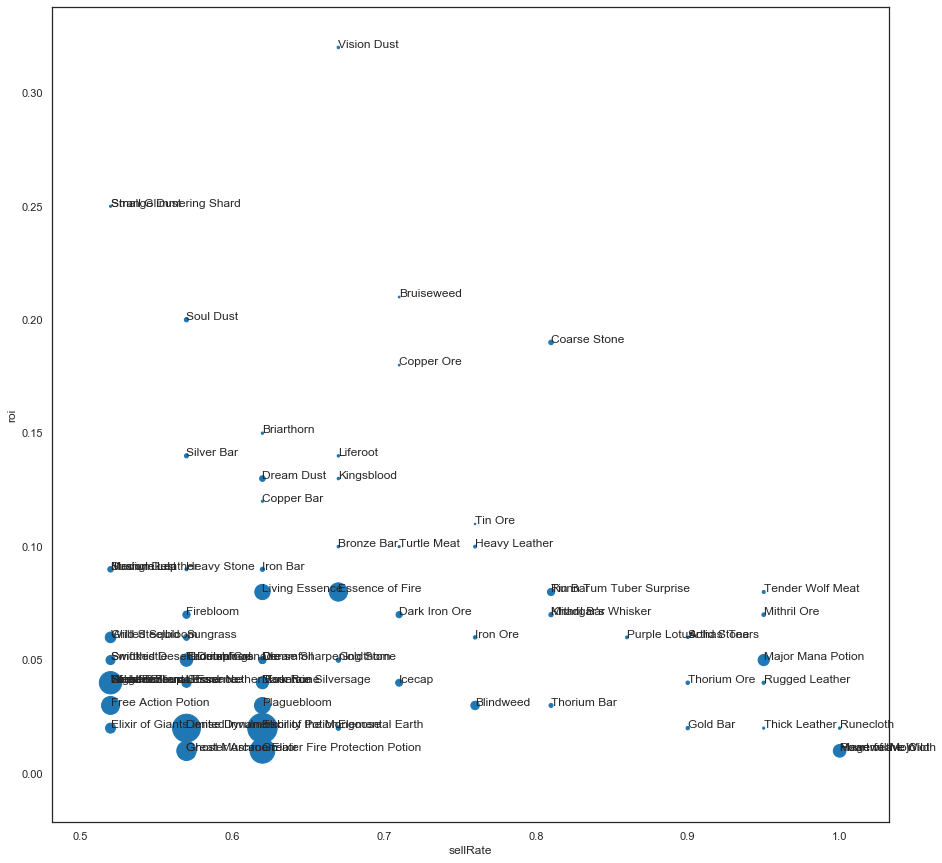

In [129]:
x = 'sellRate'
y = 'roi'
tmp = choice.query('roi < .7') # outlier
ax = tmp.plot(kind='scatter', x=x, y=y, s=choice['sellPrice'], figsize=(15,15))

for _, r in tmp.iterrows():
    ax.text(r[x], r[y], r['name'])    

### Export

In [122]:
%run EXPORT.ipynb

 
Usage:
  EXPORT(dataframe) --> expects df with specific columns
                          name         - required, string
                          item_id      - required, integer
                          buy_price    - required, integer in copper
                          min_price    - required, integer in copper 
                          normal_price - required, integer in copper
                          max_price    - required, integer in copper
                          restock      - optional, default 20
  example_export_input()  --> shows expected data schema
  example_export_output() --> shows output of example data



In [130]:
def get_export(df, max_buy_pct=.95):
    # max_buy_pct default at 95% due to 5% auction house cut
    e = df.copy()
    
    # format for export (note, 100x to scale integer copper)
    e['name'] = e.apply(lambda row: f"{int(100*row['sellRate'])}sr_{int(row['restock'])}restock_{row['name']}", axis=1)
    e['buy_price']    = 100 * e['sellPrice'] * max_buy_pct 
    e['min_price']    = 100 * e['sellPrice']
    e['normal_price'] = 100 * e['sellPrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
    e['max_price']    = 100 * e['sellPrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
    e = e.astype({'buy_price':int, 'min_price':int, 'normal_price':int, 'max_price':int})
    
    # stack_size=10 if item price is less than 1g, else stack_size=5
    e['stack_size'] = e['sellPrice'].apply(lambda x: 20 if x < 100 else 5)
    
    EXPORT(e)
    return e
e = get_export(choice, .90)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^Ss52sr_45restock_Wildvine^T^SaboveMax^SmaxPrice^SnormalPrice^S13199^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N5^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S13199^SignoreLowDuration^N0^SstackSize^N1^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S12000^SkeepQtySources^T^t^Sblacklist^S^t^SS52sr_45restock_Wildvine^T^SaboveMax^SmaxPrice^SnormalPrice^S13198^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S13198^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S11999^SkeepQtySources^T^t^Sblacklist^S^t^Ss90sr_34restock_Arthas' Tears^T^SaboveMax^SmaxPrice^S

### Inspect Results

In [16]:
t = choice.copy()
t['median'] = t['item_id'].apply(lambda x: db.get_df_hourly(x)['minBuyout'].median())
t['pctOfMedian'] = t['sellPrice'] / t['median']
t['stdNorm'] = t['item_id'].apply(lambda x: db.get_df_hourly(x)['minBuyout'].std()) / t['sellPrice']
t.sort_values(by='pctOfMedian').tail(5)

,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,flipRate,timeValue,roi,quantity,median,pctOfMedian,stdNorm
16,3821,Goldthorn,21.70,0.43,1.20,20.62,17.75,0.76,2.75,0.33,1.18,0.06,160,19.230,1.128445,0.628206
159,5634,Free Action Potion,127.49,0.43,0.60,121.12,103.27,0.63,23.62,0.27,10.12,0.10,242,109.995,1.159053,0.151399
1,8836,Arthas' Tears,5.75,0.50,0.57,5.46,4.36,0.68,0.82,0.34,0.41,0.08,104,4.840,1.188017,3.284823
71,16204,Illusion Dust,14.00,0.50,0.00,13.30,9.87,0.66,4.13,0.33,2.06,0.21,1625,10.740,1.303538,0.301034
237,10286,Heart of the Wild,7.84,0.50,2.40,7.45,4.98,0.70,0.46,0.35,0.23,0.03,128,5.640,1.390071,1.378422


,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,flipRate,timeValue,roi
77,769,Chunk of Boar Meat,5.025,0.428571,0.024,4.77375,1.384938,0.742331,3.616062,0.318142,1.549741,1.099935


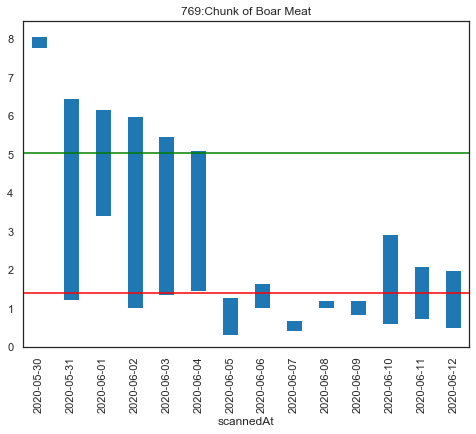

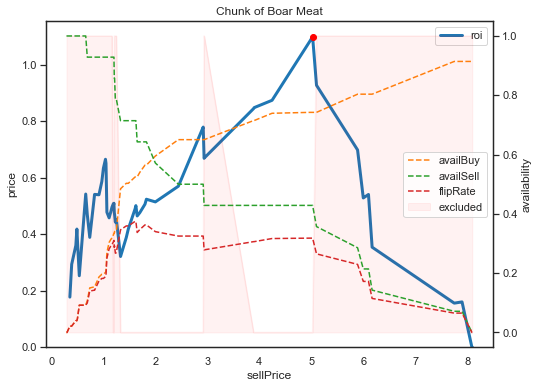

In [17]:
analysis(769, True)

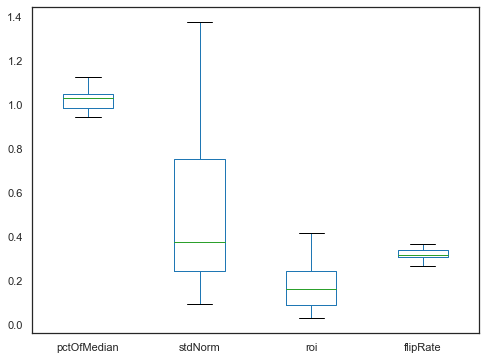

In [18]:
t.plot(kind='box', y=['pctOfMedian', 'stdNorm', 'roi', 'flipRate'], showfliers=False)

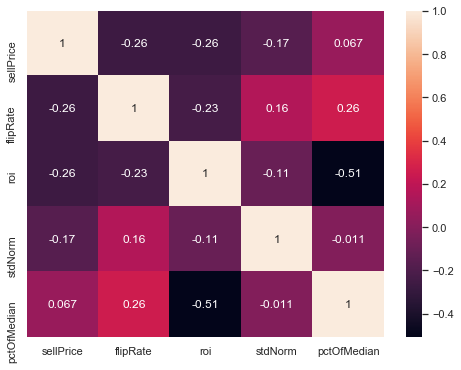

In [19]:
import seaborn as sns
tcorr = t[['sellPrice','flipRate','roi','stdNorm','pctOfMedian']].corr()
# plot the heatmap and annotation on it
sns.heatmap(tcorr, xticklabels=tcorr.columns, yticklabels=tcorr.columns, annot=True)